In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch

from Net.experiments.main_experiment import TrainExperiment, HOMO12, HOMO21, KP1, KP2, W_KP1, W_KP2, KP1_DESC, KP2_DESC, DESC1, DESC2
from Net.source.utils.common_utils import draw_cv_keypoints, torch2cv, plot_figures
from Net.source.utils.model_utils import sample_descriptors
from Net.source.utils.math_utils import calculate_inv_similarity_matrix, calculate_distance_matrix, calculate_inv_similarity_vector
from Net.source.utils.image_utils import create_coordinates_grid, create_desc_coordinates_grid, warp_points
from Net.source.hpatches_dataset import S_IMAGE1, S_IMAGE2, HOMO12, HOMO21


In [3]:
device = torch.device('cpu')

checkpoint_dir = "/home/konstantin/PycharmProjects/Summertime/Net/checkpoints/net_default"

experiment = TrainExperiment(device, None, checkpoint_dir, 1000)

In [4]:
batch = experiment.analyze_inference()

In [5]:
cv_s_image1 = torch2cv(batch[S_IMAGE1].squeeze(0))
cv_s_image2 = torch2cv(batch[S_IMAGE2].squeeze(0))

kp1 = batch[KP1]
kp2 = batch[KP2]

w_kp1 = batch[W_KP1]
w_kp2 = batch[W_KP2]

kp1_desc = batch[KP1_DESC]
kp2_desc = batch[KP2_DESC]

desc1 = batch[DESC1]
desc2 = batch[DESC2]

homo12 = batch[HOMO12]
homo21 = batch[HOMO21]

In [94]:
# FOS 

num_neg = 1
grid_size = 8
margin = 1
loss_lambda = 1


b, n, c = kp1_desc.size()

w_kp1_desc = sample_descriptors(desc2, w_kp1, grid_size)

# Take positive matches
positive_sim = calculate_inv_similarity_vector(kp1_desc, w_kp1_desc)
positive_sim = positive_sim.view(b, n, 1).repeat(1, 1, num_neg).view(b, n * num_neg)

# Create neighbour mask
coo_grid = create_desc_coordinates_grid(desc1, grid_size).view(desc1.size(0), -1, 2)

kp1_coo_dist = calculate_distance_matrix(kp1, coo_grid)
_, kp1_cell_ids = kp1_coo_dist.topk(k=4, largest=False, dim=-1)

kp1_cell_ids = kp1_cell_ids.view(b, -1).unsqueeze(-1).repeat(1, 1, 2)
kp1_cells = coo_grid.gather(dim=1, index=kp1_cell_ids)

kp1_w_cells = warp_points(kp1_cells, homo12)

kp1_wc_coo_dist = calculate_distance_matrix(kp1_w_cells, coo_grid)
_, kp1_w_cell_cell_ids = kp1_wc_coo_dist.topk(k=4, largest=False, dim=-1)

neigh_mask = torch.zeros_like(kp1_wc_coo_dist).to(kp1_wc_coo_dist)
neigh_mask = neigh_mask.scatter(dim=-1, index=kp1_w_cell_cell_ids, value=1)
neigh_mask = neigh_mask.view(b, n, 4, -1).sum(dim=2).float()

# Calculate similarity
desc2 = desc2.permute((0, 2, 3, 1)).view(b, -1, c)
desc_sim = calculate_inv_similarity_matrix(kp1_desc, desc2)

#  Apply neighbour mask and get negatives
desc_sim = desc_sim + neigh_mask * 5
neg_sim = desc_sim.topk(k=num_neg, dim=-1, largest=False)[0].view(b, -1)

fos = (torch.clamp(positive_sim - neg_sim + margin, min=0) ** 2).mean() * loss_lambda

print(fos)

tensor(0.6925)


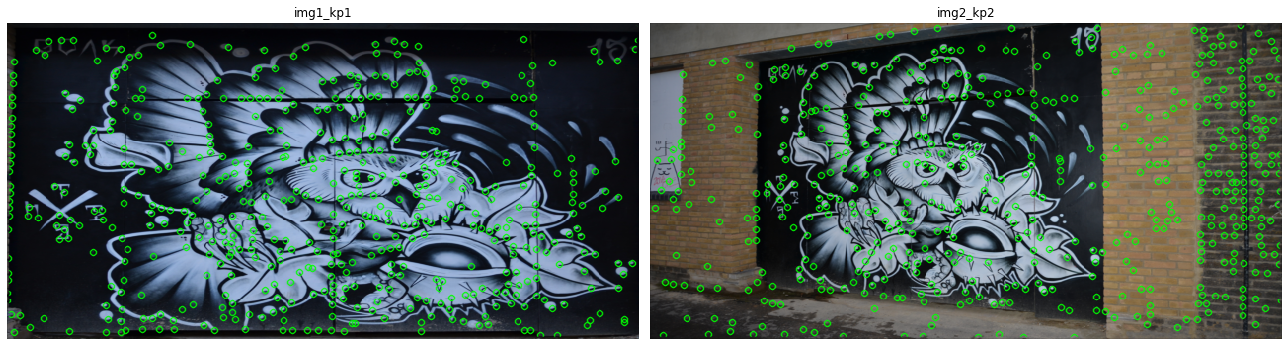

In [31]:
cv_kp1_image = draw_cv_keypoints(cv_s_image1, kp1.squeeze(0), (0, 255, 0))
cv_kp2_image = draw_cv_keypoints(cv_s_image2, kp2.squeeze(0), (0, 255, 0))

plot_figures({'img1_kp1': cv_kp1_image,
              'img2_kp2': cv_kp2_image}, 1, 2, (18, 9))

In [32]:
kp_id = 200

kp1_cells = kp1_cells.view(b, n, 4, 2)
w_kp1_cells = kp1_w_cells.view(b, n, 4, 2)

kp1_closest = kp1_cells[0, kp_id]
w_kp1_closest = kp1_w_cells.view(b, n, 4, 2)[0, kp_id]

kp2_closest = coo_grid[0, neigh_mask[0, kp_id].nonzero()].squeeze(1)

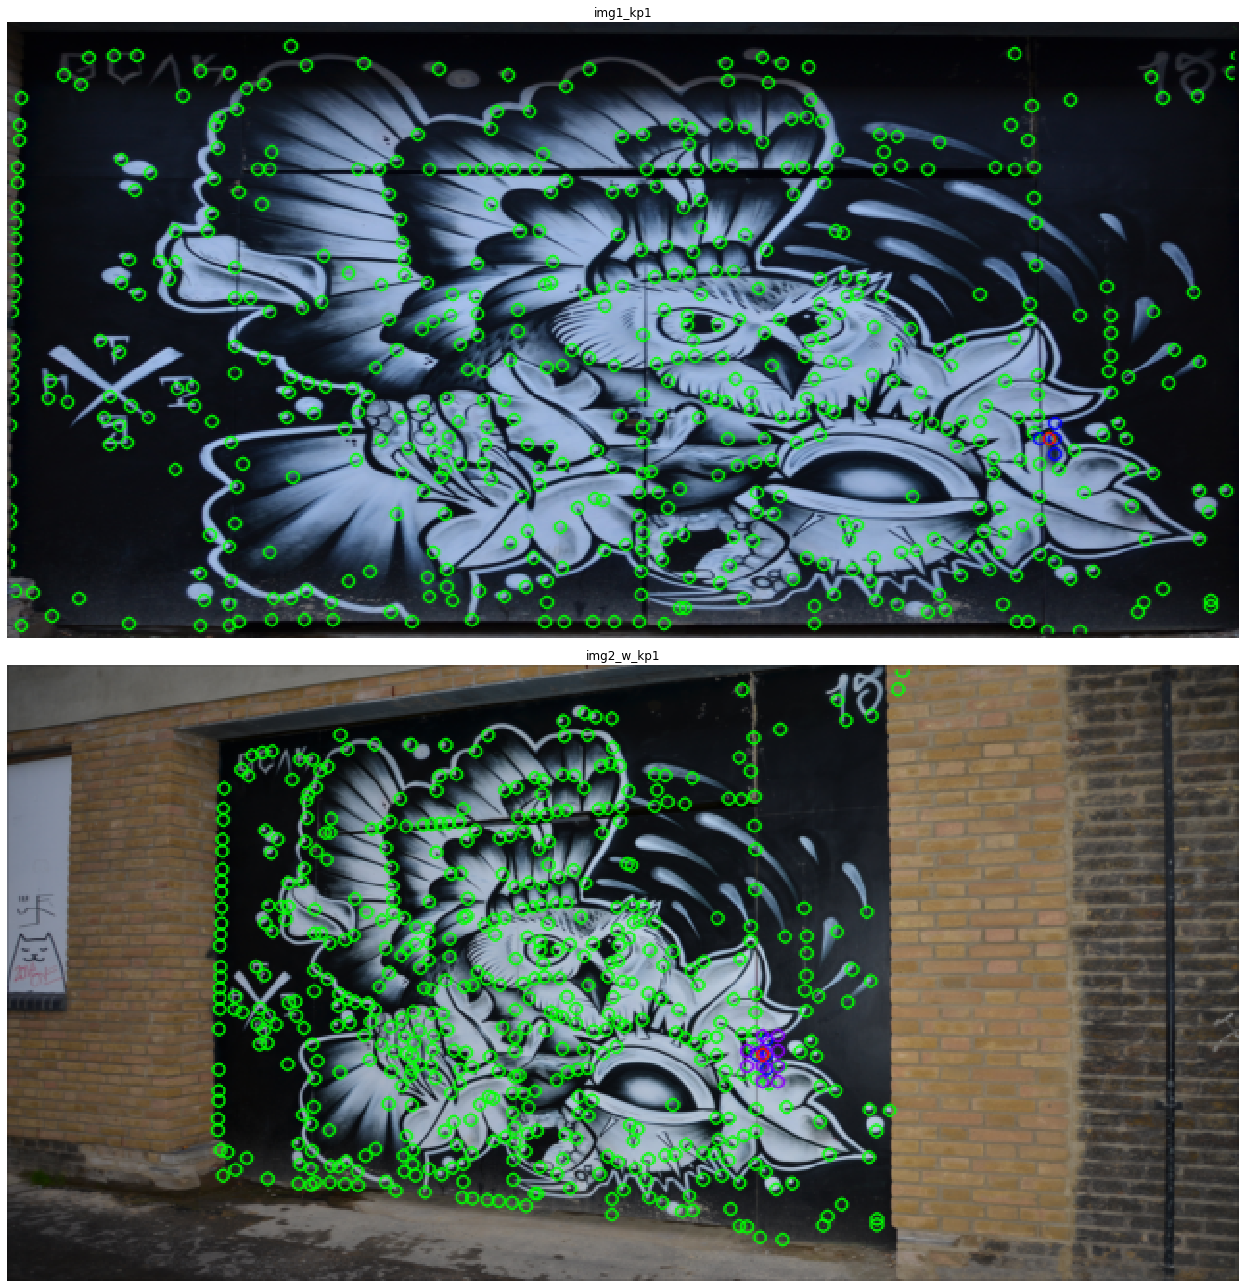

In [33]:
cv_w_kp1_image = draw_cv_keypoints(cv_s_image2, w_kp1.squeeze(0), (0, 255, 0))

res_image1 = draw_cv_keypoints(cv_kp1_image, kp1_closest, (0, 0, 255))
res_image1 = draw_cv_keypoints(res_image1, kp1.squeeze(0)[None, kp_id], (255, 0, 0))

res_image2 = draw_cv_keypoints(cv_w_kp1_image, w_kp1_closest, (0, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, kp2_closest, (139, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, w_kp1.squeeze(0)[None, kp_id], (255, 0, 0))

plot_figures({'img1_kp1': res_image1,
              'img2_w_kp1': res_image2}, 2, 1, (18, 18))

In [95]:
batch = experiment.analyze_inference()

In [96]:
cv_s_image1 = torch2cv(batch[S_IMAGE1].squeeze(0))
cv_s_image2 = torch2cv(batch[S_IMAGE2].squeeze(0))

kp1 = batch[KP1]
kp2 = batch[KP2]

w_kp1 = batch[W_KP1]
w_kp2 = batch[W_KP2]

kp1_desc = batch[KP1_DESC]
kp2_desc = batch[KP2_DESC]

desc1 = batch[DESC1]
desc2 = batch[DESC2]

homo12 = batch[HOMO12]
homo21 = batch[HOMO21]

In [97]:
# SOS
grid_size = 8
sos_neg = 8

w_kp1_desc = sample_descriptors(desc2, w_kp1, grid_size)

kp1_cells = kp1_cells.view(b, n * 4, 2)

kp1_cells_dist = calculate_distance_matrix(kp1_cells, kp1_cells)
kp1_mask = (kp1_cells_dist <= 1e-8).view(b, n, 4, n, 4).sum(-1).sum(2).float()

kp1_w_cell_cell_ids = kp1_w_cell_cell_ids.view(b, -1).unsqueeze(-1).repeat(1, 1, 2)
kp1_w_cell_cells = coo_grid.gather(dim=1, index=kp1_w_cell_cell_ids)

w_kp1_coo_dist = calculate_distance_matrix(w_kp1, coo_grid)
_, w_kp1_cell_ids = w_kp1_coo_dist.topk(k=4, largest=False, dim=-1)

w_kp1_cell_ids = w_kp1_cell_ids.view(b, -1).unsqueeze(-1).repeat(1, 1, 2)
w_kp1_cells = coo_grid.gather(dim=1, index=w_kp1_cell_ids)

kp1_wc_w_kp1_dist = calculate_distance_matrix(kp1_w_cell_cells, w_kp1_cells)
w_kp1_mask = (kp1_wc_w_kp1_dist <= 1e-8).view(b, n, 4, 4, n, 4).sum(-1).sum(3).sum(2).float()

kp1_sim = calculate_inv_similarity_matrix(kp1_desc, kp1_desc)
w_kp1_sim = calculate_inv_similarity_matrix(w_kp1_desc, w_kp1_desc)

kp1_sim = kp1_sim +  kp1_mask * 5
w_kp1_sim = w_kp1_sim + w_kp1_mask * 5

_, kp1_neg_ids = kp1_sim.topk(k=sos_neg, dim=-1, largest=False)
_, w_kp1_neg_ids = w_kp1_sim.topk(k=sos_neg, dim=-1, largest=False)

kp1_neg_ids = kp1_neg_ids.view(b, n * sos_neg).unsqueeze(-1).repeat(1, 1, c)
w_kp1_neg_ids = w_kp1_neg_ids.view(b, n * sos_neg).unsqueeze(-1).repeat(1, 1, c)

kp1_neg_desc = kp1_desc.gather(dim=1, index=kp1_neg_ids)
w_kp1_neg_desc = w_kp1_desc.gather(dim=1, index=w_kp1_neg_ids)

kp1_desc = kp1_desc.unsqueeze(2).repeat(1, 1, sos_neg, 1).view(b, n * sos_neg, c)
w_kp1_desc = w_kp1_desc.unsqueeze(2).repeat(1, 1, sos_neg, 1).view(b, n * sos_neg, c)

sos = calculate_inv_similarity_vector(kp1_desc, kp1_neg_desc) - calculate_inv_similarity_vector(w_kp1_desc, w_kp1_neg_desc)

sos = (sos ** 2).view(b, n, sos_neg).sum(-1).sqrt().mean()

print(sos)

tensor(0.1405)


In [98]:
kp_id = 210

kp1_closest = kp1[0, kp1_mask[0, kp_id].nonzero()].squeeze(1)
w_kp1_closest = w_kp1[0, w_kp1_mask[0, kp_id].nonzero()].squeeze(1)

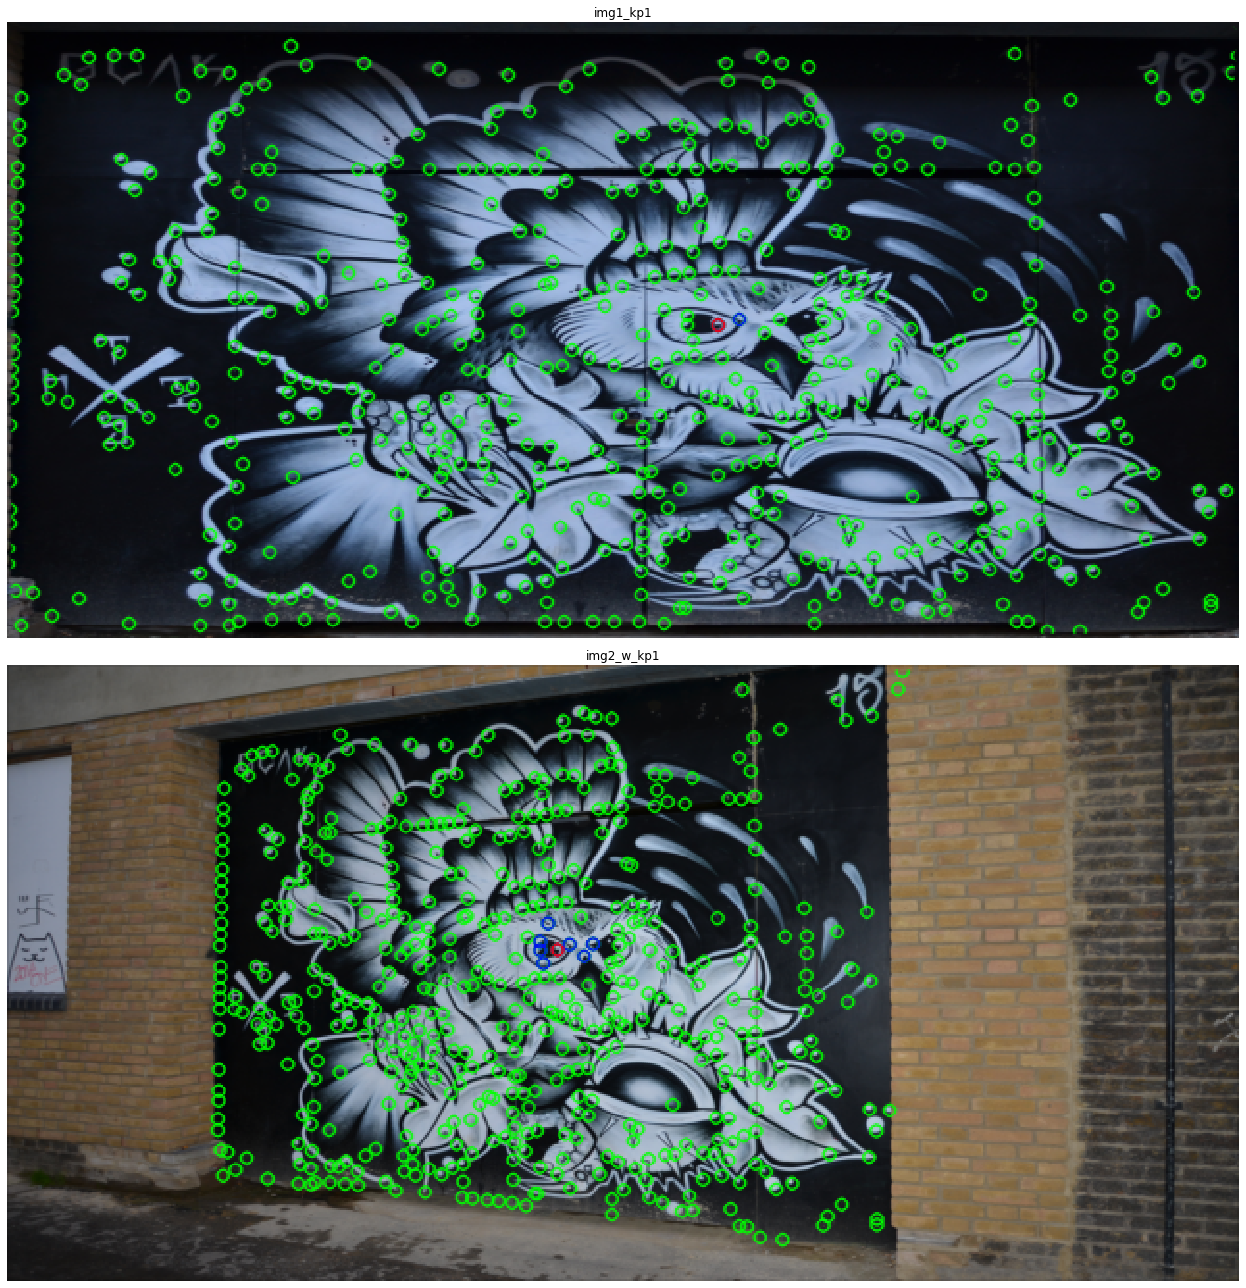

In [99]:
res_image1 = draw_cv_keypoints(cv_kp1_image, kp1_closest, (0, 0, 255))
res_image1 = draw_cv_keypoints(res_image1, kp1.squeeze(0)[None, kp_id], (255, 0, 0))

res_image2 = draw_cv_keypoints(cv_w_kp1_image, w_kp1_closest, (0, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, w_kp1.squeeze(0)[None, kp_id], (255, 0, 0))

plot_figures({'img1_kp1': res_image1,
              'img2_w_kp1': res_image2}, 2, 1, (18, 18))